In [104]:
import math
import matplotlib.pyplot as plt
from enum import Enum
import random
import pandas as pd
import numpy as np
import heapq

In [105]:
def inp(t):
    """I(t) = 0"""
    return 0 * t

class NeuronType(Enum):
    excitatory = 1,
    inhibitory = 0

class LeakyIntegrateAndFire:
    def __init__(self,
                 u_rest=-70,
                 resistance=10,
                 capacitance=0.8,
                 time=100,
                 dt=0.1,
                 threshold=-45,
                 u_reset=-65,
                 u_start=-80,
                 input_current=inp,
                 is_exponential=False,
                 delta_tt=1,
                 theta_rh=-55,
                 is_adaptive=False,
                 tau_w=1,
                 a=0.01,
                 b=0.5,
                 n_t=NeuronType.excitatory):

        self.current_time = 0.0
        self.u_start = u_start
        self.u_rest = u_rest
        self.u_reset = u_reset
        self.resistance = resistance
        self.capacitance = capacitance
        self.time = time
        self.dt = dt
        self.threshold = threshold
        self.input_current = input_current
        self.is_exponential = is_exponential
        self.delta_tt = delta_tt
        self.theta_rh = theta_rh
        self.is_adaptive = is_adaptive
        self.tau_w = tau_w
        self.a = a
        self.b = b
        self.tau = self.resistance * self.capacitance
        self.u_t = []
        self.last_spike = -1
        self.sigma_delta_func = 0
        self.u = u_start
        self.w = 0
        self.n_t = n_t
        self.spike_count = 0
        self.spikes = []

    def initiate(self):
        while self.current_time <= self.time:
            self.__fu(self.current_time)
            yield self.sigma_delta_func
            self.current_time += self.dt

    def __fu(self, current_time):
        exp_val = 0
        input_value = self.input_current(current_time)

        if self.is_exponential:
            exp_val = self.delta_tt * math.exp((self.u - self.theta_rh) / self.delta_tt)
        du = self.dt * (-(self.u - self.u_rest) + exp_val - self.resistance * self.w +
                        self.resistance * input_value) / self.tau

        if self.is_adaptive:
            dw = (self.dt / self.tau_w) * (self.a * (self.u - self.u_rest)
                                           - self.w + self.b * self.tau_w * self.sigma_delta_func)
            self.w += dw
        self.u += du
        self.sigma_delta_func = 0

        if self.check_spikes():
            self.last_spike = current_time
            self.spike_count += 1
            self.spikes.append(current_time)
        self.u_t.append(self.u)

    def u_t_plot(self):
        plt.plot(list(map(lambda i: i * self.dt, range(len(self.u_t)))), self.u_t)
        plt.ylabel('U')
        plt.xlabel('Time')
        plt.title('U-T plot')
        plt.grid(True)
        plt.show()

    def check_spikes(self):
        if self.u >= self.threshold:
            self.u = self.u_reset
            self.sigma_delta_func = 1
            return True
        return False

    def reset(self):
        self.hard_reset()
        pass

    def hard_reset(self):
        self.sigma_delta_func = 0
        self.u = self.u_start
        self.spikes = []
        self.u_t = []
        self.spike_count = 0
        self.current_time = 0


class LeakyIntegrateAndFire2:
    def __init__(self,
                 u_rest=-70,
                 resistance=10,
                 capacitance=0.8,
                 time=100,
                 dt=0.1,
                 threshold=-45,
                 u_reset=-65,
                 u_start=-80):
        self.current_time = 0.0
        self.u_start = u_start
        self.u_rest = u_rest
        self.u_reset = u_reset
        self.resistance = resistance
        self.capacitance = capacitance
        self.time = time
        self.dt = dt
        self.threshold = threshold
        self.tau = self.resistance * self.capacitance
        self.u_t = []
        self.last_spike = -1
        self.sigma_delta_func = 0
        self.u = u_start
        self.spike_count = 0
        self.spikes = []

    def single_step(self, current, time, dt):
        du = dt * (-1 * (self.u - self.u_rest) + 1e-3 * self.resistance * current) / self.tau
        self.u += du
        time += dt
        self.sigma_delta_func = 0
        if self.u > self.threshold:
            self.u = self.u_reset
            self.sigma_delta_func = 1
            self.last_spike = time
            self.spike_count += 1
            self.spikes.append(time)
        self.u_t.append(self.u)

    def reset(self):
        self.u_t = []
        self.spikes = []
        self.spike_count = 0
        self.u = self.u_rest

In [106]:
class NeuronsGroup:
    def __init__(self,
                 neurons,
                 connections,
                 weight_matrix,
                 delay=1,
                 iteration_count=1000):
        self.neurons = neurons
        self.neuron_action = []
        self.connections = connections
        self.weight_matrix = weight_matrix
        self.delay = delay
        self.iteration_count = iteration_count
        self.spikes = []
        self.excitatory_spike_times = []
        self.excitatory_spikes = []
        self.inhibitory_spike_times = []
        self.inhibitory_spikes = []
        self.spikes_effect = [[0] * len(self.neurons) for _ in range(self.iteration_count)]

        for neuron in neurons:
            self.neuron_action.append(neuron.initiate())

    def initiate(self):
        for time in range(self.iteration_count):
            for i in range(len(self.neuron_action)):
                sigma_delta_func = next(self.neuron_action[i])
                if sigma_delta_func == 1:
                    if self.neurons[i].n_t is NeuronType.excitatory:
                        for j in self.connections[i]:
                            self.excitatory_spikes.append(i + 1)
                            self.excitatory_spike_times.append(time)
                            if time + self.delay < self.iteration_count:
                                self.spikes_effect[time + self.delay][j] += self.weight_matrix[i][j]
                    else:
                        for j in self.connections[i]:
                            self.inhibitory_spikes.append(i + 1)
                            self.inhibitory_spike_times.append(time)
                            if time + self.delay < self.iteration_count:
                                self.spikes_effect[time + self.delay][j] -= self.weight_matrix[i][j]

            for i in range(len(self.neurons)):
                self.neurons[i].u += self.spikes_effect[time][i]
            yield True
        yield False

    def u_plot(self, neurons_count):
        legend = []
        for i in range(min(len(self.neurons), neurons_count)):
            plt.plot(list(map(lambda j: j * self.neurons[i].dt, range(len(self.neurons[i].u_t)))), self.neurons[i].u_t)
            legend.append('neuron ' + str(i + 1))
        plt.legend(legend)

    def raster_plot(self):
        plt.scatter(self.excitatory_spike_times, self.excitatory_spikes, color='blue', s=10)
        plt.scatter(self.inhibitory_spike_times, self.inhibitory_spikes, color='red', s=10)
        plt.legend(['blue:Excitatory', 'red:Inhibitory'])

    def reset(self):
        self.spikes = []
        self.excitatory_spike_times = []
        self.excitatory_spikes = []
        self.inhibitory_spike_times = []
        self.inhibitory_spikes = []
        self.spikes_effect = [[0] * len(self.neurons) for _ in range(self.iteration_count)]
        self.neuron_action = []

        for neuron in self.neurons:
            neuron.reset()
            self.neuron_action.append(neuron.initiate())

    @staticmethod
    def create_neuron_group(neurons_count, excitatory_count, inhibitory_count,
                            excitatory_probability, inhibitory_probability, input_current, **kwargs):
        neurons = []
        connections = []
        exc_neuron_conn_count = int(neurons_count * excitatory_probability)
        inh_neuron_conn_count = int(neurons_count * inhibitory_probability)

        for i in range(excitatory_count):
            args = {}
            if 'Excitatory' in kwargs.keys():
                for arg in kwargs['Excitatory']:
                    args[arg] = kwargs[arg][i]
            neuron = LeakyIntegrateAndFire(input_current=input_current[i], n_t=NeuronType.excitatory, **args)
            neurons.append(neuron)
            connections.append(random.sample(range(neurons_count), exc_neuron_conn_count))
            
        for i in range(inhibitory_count):
            args = {}
            if 'Inhibitory' in kwargs.keys():
                for arg in kwargs['Inhibitory']:
                    args[arg] = kwargs[arg][i]
            neuron = LeakyIntegrateAndFire(input_current=input_current[i], n_t=NeuronType.inhibitory, **args)
            neurons.append(neuron)
            connections.append(random.sample(range(neurons_count), inh_neuron_conn_count))

        return NeuronsGroup(neurons, connections, **kwargs)

In [107]:
class STDP:
    def __init__(self,
                 neurons_group:NeuronsGroup,
                 amplify_val_pos,
                 amplify_val_neg,
                 delta_tau_pos,
                 delta_tau_neg):
        self.neurons_gp = neurons_group
        self.amplify_val_pos = amplify_val_pos
        self.amplify_val_neg = amplify_val_neg
        self.delta_tau_pos = delta_tau_pos
        self.delta_tau_neg = delta_tau_neg
        self.w_history = []
        self.neurons_gp.reset()

    def train(self):
        func = self.neurons_gp.initiate()
        while next(func):
            temp = []
            for w1 in self.neurons_gp.weight_matrix:
                temp2 = []
                for w2 in w1:
                    temp2.append(w2)
                temp.append(temp2)
            self.w_history.append(temp)

            for i in range(len(self.neurons_gp.neurons)):
                for j in self.neurons_gp.connections[i]:
                    delta_t = self.neurons_gp.neurons[j].last_spike - self.neurons_gp.neurons[i].last_spike
                    delta_w = 0

                    if self.neurons_gp.neurons[j].last_spike != -1 or self.neurons_gp.neurons[i].last_spike != -1:
                        if delta_t < 0:
                            delta_w = self.amplify_val_neg * math.exp(math.fabs(delta_t)/self.delta_tau_neg)
                        elif delta_t > 0:
                            delta_w = self.amplify_val_pos * math.exp(math.fabs(delta_t)/self.delta_tau_pos)
                    self.neurons_gp.weight_matrix[i][j] += delta_w

                    if self.neurons_gp.weight_matrix[i][j] <= 0:
                        self.neurons_gp.weight_matrix[i][j] = 0

    def w_plot(self, i, j):
        w_t = []
        for table in self.w_history:
            w_t.append(table[i][j])
        plt.plot(list(map(lambda k: k * self.neurons_gp.neurons[i].dt, range(len(w_t)))), w_t)
        plt.ylabel('Weight between neurons ' + str(i) + ' and' + str(j))
        plt.xlabel('Time')
        plt.title('W-T plot')
        plt.grid(True)
        plt.show()

In [108]:
class SNN:

    def __init__(self,
                 network_dim,
                 neurons,
                 tau_tag,
                 tau_dopamine,
                 reward_score):
        self.network_dim = network_dim
        self.network_neurons = neurons
        self.connections = []
        self.tau_dopamine = tau_dopamine
        self.tau_tag = tau_tag
        self.tags = []
        self.reward_score = reward_score
        self.connect_network()
        self.dopamine = 0

    def connect_network(self):
        for i in range(0, len(self.network_dim) - 1):
            self.connections.append(np.ones((self.network_dim[i], self.network_dim[i + 1])) * 8 + np.random.rand())
            self.tags.append(np.zeros((self.network_dim[i], self.network_dim[i + 1])))

    def fit(self, x, y, dt, epoch_time, dt_minus, dt_plus, a_minus, a_plus, time_course_threshold, iterations,
            learn_time):
        time = 0
        lt = learn_time
        for iteration in range(iterations):
            index = np.random.randint(0, x.shape[0])
            epoch = 0
            while epoch < epoch_time:
                inputs = x[index]
                for layer in range(len(self.network_neurons)):
                    for i, neuron in enumerate(self.network_neurons[layer]):
                        neuron.single_step(inputs[i], time, dt)
                    if layer != len(self.network_neurons) - 1:
                        activities = self.calculate_activity_history(layer, time + dt, dt, time_course_threshold)
                        inputs = activities @ self.connections[layer]

                flag = False
                if time > lt:
                    flag = True
                    lt += learn_time
                self.train(y, index, time + dt, dt, dt_minus, dt_plus, a_minus, a_plus, learn_time, flag)

                epoch += dt
                time += dt

    def train(self, y, index, time, dt, dt_minus, dt_plus, a_minus, a_plus, learn_time, flag):
        for layer in range(len(self.connections)):
            for i in range(len(self.network_neurons[layer])):
                for j in range(len(self.network_neurons[layer + 1])):
                    pre_neuron = self.network_neurons[layer][i]
                    post_neuron = self.network_neurons[layer][j]
                    stdp = 0

                    if pre_neuron.spike_count != 0 and post_neuron.spike_count != 0 and post_neuron.spikes[-1] == time:
                        dt = abs(post_neuron.spikes[-1] - pre_neuron.spikes[-1])
                        if post_neuron.spikes[-1] > pre_neuron.spikes[-1]:
                            stdp += a_plus * math.exp(-(dt / dt_plus))
                        if post_neuron.spikes[-1] < pre_neuron.spikes[-1]:
                            stdp += a_minus * math.exp(-(dt / dt_minus))

                    self.tags[layer][i, j] += dt * ((-self.tags[layer][i, j] / self.tau_tag) + stdp)
                    self.connections[layer][i, j] += dt * (self.tags[layer][i, j] * self.dopamine)
                    if self.connections[layer][i, j] < 0:
                        self.connections[layer][i, j] = 0

        reward = 0
        if flag:
            actions = np.zeros_like(self.network_neurons[-1])
            for i, neuron in enumerate(self.network_neurons[-1]):
                amount = 0
                for spike in reversed(neuron.spikes):
                    if time - spike > learn_time:
                        amount += 1
                actions[i] = amount
            if np.argmax(actions) == int(y[index]):
                largest_integers = heapq.nlargest(2, list(actions))
                if largest_integers[0] != 0 and (largest_integers[0] - largest_integers[1]) / largest_integers[0] > 0.1:
                    reward += self.reward_score
                else:
                    reward -= self.reward_score
            else:
                reward -= self.reward_score
        self.dopamine += learn_time * ((-self.dopamine / self.tau_dopamine) + reward)

    def calculate_activity_history(self, layer, time, dt, time_course_threshold):
        activity_list = np.zeros(self.network_dim[layer])
        for idx in range(self.network_dim[layer]):
            activity_list[idx] = self.calculate_activity_history_single(layer, idx, time, dt, time_course_threshold)
        return activity_list

    def calculate_activity_history_single(self, layer, index, time, dt, time_course_threshold):
        neuron = self.network_neurons[layer][index]
        s = 0
        activity = 0
        while self.time_course(s) > time_course_threshold:
            if (time - s) in neuron.spikes:
                activity += self.time_course(s)
            s += dt
        return activity

    def predict(self, x, time_interval, dt, time_course_threshold):
        results = np.zeros((len(x)))
        for i in range(len(x)):
            self.reset()
            time = 0
            while time < time_interval:
                inputs = x[i]
                for layer in range(len(self.network_neurons)):
                    for k, neuron in enumerate(self.network_neurons[layer]):
                        neuron.single_step(current=inputs[k], time=time, dt=dt)
                    if layer != len(self.network_neurons) - 1:
                        activities = self.calculate_activity_history(layer, time + dt, dt, time_course_threshold)
                        inputs = activities @ self.connections[layer]
                time += dt

            if self.network_neurons[-1][0].spike_count > self.network_neurons[-1][1].spike_count:
                results[i] = 0
            else:
                results[i] = 1

        return results

    def reset(self):
        for i in range(len(self.network_neurons)):
            for neuron in self.network_neurons[i]:
                neuron.reset()

    @staticmethod
    def time_course(s):
        sigma = 7.5
        return 250 * (1 / (sigma * math.sqrt(2 * math.pi))) * math.exp(-(s / sigma) ** 2)

In [109]:
const = lambda x: 200 * (math.sqrt(math.fabs(math.sin(x))))

neuron1 = LeakyIntegrateAndFire(input_current=const, threshold=-60)
neuron2 = LeakyIntegrateAndFire(input_current=const)
neuron3 = LeakyIntegrateAndFire(input_current=const)

connections = [[1, 2], [0, 2], [0, 1]]
neurons = [neuron1, neuron2, neuron3]

weight_matrix = []

for i in range(3):
    temp = []
    for j in range(3):
        temp.append(random.randint(8, 14))
    weight_matrix.append(temp)

for i in range(3):
    weight_matrix[i][i] = 0
print(weight_matrix)
ng = NeuronsGroup(neurons=neurons, connections=connections, weight_matrix=weight_matrix)
STDP = STDP(neurons_group=ng, amplify_val_pos=10, amplify_val_neg=-10, delta_tau_pos=0.2, delta_tau_neg=0.2)
STDP.train()

[[0, 11, 13], [10, 0, 10], [8, 10, 0]]


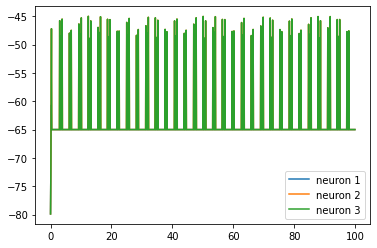

In [110]:
ng.u_plot(3)

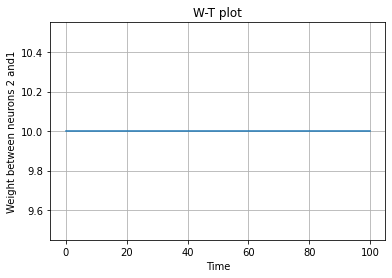

In [127]:
STDP.w_plot(2, 1)

In [112]:
neurons = []
layers = [5, 2]

for i in layers:
    layer = []
    for _ in range(i):
        layer.append(LeakyIntegrateAndFire2(u_rest=random.randint(-85, -65), resistance=random.randint(1, 10), capacitance=random.randint(5, 8)/10, threshold=random.randint(-40, -35), u_reset=random.randint(-70, -65), u_start=random.randint(-75, -70)))
    neurons.append(layer)

In [113]:
weight_matrix = []
connections = []

for i in range(len(layers) - 1):
    layer = []
    layer2 = []
    for j in range(layers[i]):
        neuron = []
        neuron2 = []
        for k in range(layers[i+1]):
            neuron.append(1)
            neuron2.append(k)
        layer.append(neuron)
        layer2.append(neuron2)
    weight_matrix.append(layer)
    connections.append(layer2)
print(weight_matrix)
print(connections)

[[[1, 1], [1, 1], [1, 1], [1, 1], [1, 1]]]
[[[0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]]


In [114]:
dataset = pd.read_excel('./CN_3_DATASET.xlsx')

x_train = dataset.iloc[1:6,1:].values.T * 10000
y_train = dataset.iloc[6,1:].values
x_test = dataset.iloc[10:15,1:].values.T * 10000
y_test = dataset.iloc[15,1:].values

In [115]:
model = SNN(network_dim=(5,2), neurons=neurons, tau_tag=15, tau_dopamine=12, reward_score=7)

In [116]:
model.fit(x=x_train, y=y_train, dt=0.1, epoch_time=5, dt_minus=7, dt_plus=9, a_minus=-4, a_plus=+7, time_course_threshold=1, iterations=100, learn_time=0.5)

In [117]:
a = model.predict(x_train, 100, 0.1, time_course_threshold=1)
print(a)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [118]:
count = 0
for i, el in enumerate(a):
    if el == y_train[i]:
        count +=1
print(count / len(a))

0.6


In [119]:
a = model.predict(x_test, 100, 0.1, time_course_threshold=1)

In [120]:
count = 0
for i, el in enumerate(a):
    if el == y_test[i]:
        count +=1
print(count / len(a))

0.6


In [121]:
print(a)
print(y_test)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1 1 1 1 1 0 0 0 1 0]
